In [8]:
!pip install numpy nibabel matplotlib torch torchvision monai opencv-python grad-cam

  Using cached torch-2.6.0-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached monai-1.4.0-py3-none-any.whl.metadata (11 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached grad-cam-1.5.4.tar.gz (7.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached ttach-0.0.3-py3-none-any.whl.metadata (5.2 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/204.1 MB 2.4 MB/s eta 0:01:26
   ---------------------------------------- 0.5/204.1 MB 2.4 MB/s eta

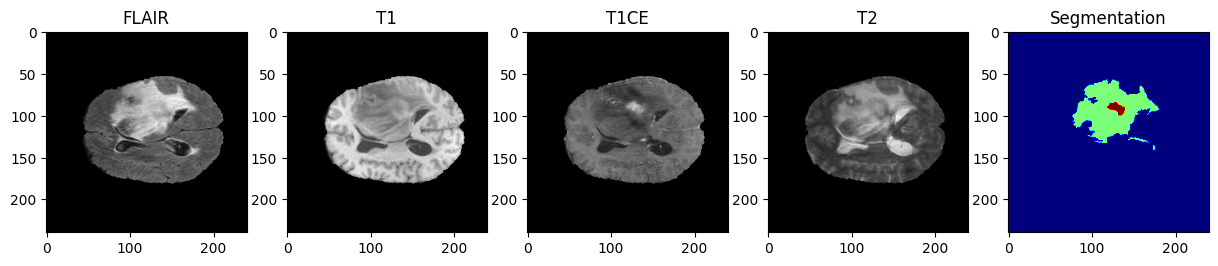

In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt

# Set dataset path
data_path = r"D:\Major_Project_(CSE)\Brain_Tumor_Detection\dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData/BraTS20_Training_001"

# Load MRI scans
flair = nib.load(os.path.join(data_path, "BraTS20_Training_001_flair.nii")).get_fdata()
t1 = nib.load(os.path.join(data_path, "BraTS20_Training_001_t1.nii")).get_fdata()
t1ce = nib.load(os.path.join(data_path, "BraTS20_Training_001_t1ce.nii")).get_fdata()
t2 = nib.load(os.path.join(data_path, "BraTS20_Training_001_t2.nii")).get_fdata()
seg = nib.load(os.path.join(data_path, "BraTS20_Training_001_seg.nii")).get_fdata()

# Plot one MRI slice
plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1); plt.imshow(flair[:, :, 80], cmap="gray"); plt.title("FLAIR")
plt.subplot(1, 5, 2); plt.imshow(t1[:, :, 80], cmap="gray"); plt.title("T1")
plt.subplot(1, 5, 3); plt.imshow(t1ce[:, :, 80], cmap="gray"); plt.title("T1CE")
plt.subplot(1, 5, 4); plt.imshow(t2[:, :, 80], cmap="gray"); plt.title("T2")
plt.subplot(1, 5, 5); plt.imshow(seg[:, :, 80], cmap="jet"); plt.title("Segmentation")
plt.show()


In [6]:
import os
import numpy as np
import torch
import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, 
    Spacingd, ResizeWithPadOrCropd, ToTensord
)
from monai.data import Dataset, DataLoader

# Set dataset path (fixing slashes)
data_path = r"D:\Major_Project_(CSE)\Brain_Tumor_Detection\dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

# Detect file extensions
example_case = os.listdir(data_path)[0]  # First case folder
example_case_path = os.path.join(data_path, example_case)
example_files = os.listdir(example_case_path)

# Determine if .nii.gz or .nii
ext = ".nii.gz" if any(f.endswith(".nii.gz") for f in example_files) else ".nii"

# Load data files
train_files = []
for case in os.listdir(data_path):
    case_path = os.path.join(data_path, case)
    if os.path.isdir(case_path):
        flair_path = os.path.join(case_path, f"{case}_flair{ext}")
        seg_path = os.path.join(case_path, f"{case}_seg{ext}")
        
        if os.path.exists(flair_path) and os.path.exists(seg_path):
            train_files.append({"image": flair_path, "label": seg_path})
        else:
            print(f"‚ö†Ô∏è Skipping {case}: Missing files.")  # Debugging message

print(f"‚úÖ Total valid cases: {len(train_files)}")  # Debugging message

# Define transformations
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 128)),
    ToTensord(keys=["image", "label"]),
])

# Create dataset and dataloader
train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Check batch shapes
for batch in train_loader:
    print(f"üü¢ Batch Image Shape: {batch['image'].shape}, Batch Label Shape: {batch['label'].shape}")
    break


‚ö†Ô∏è Skipping BraTS20_Training_355: Missing files.
‚úÖ Total valid cases: 368
üü¢ Batch Image Shape: torch.Size([2, 1, 128, 128, 128]), Batch Label Shape: torch.Size([2, 1, 128, 128, 128])


In [4]:
import torch
import monai
from monai.networks.nets import UNet

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"üîç Using device: {device}")

# Define 3D U-Net model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,  # Binary segmentation (tumor vs. background)
    channels=(16, 32, 64, 128, 256),  # Number of filters in each layer
    strides=(2, 2, 2, 2),  # Downsampling
    num_res_units=2,  # Residual units for better learning
).to(device)

# Print model summary
print(model)


üîç Using device: cuda
UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUn

In [7]:
import torch.optim as optim
from monai.losses import DiceLoss

# Define loss function
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional, helps with convergence)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("‚úÖ Training setup completed: Loss function, Optimizer, and LR Scheduler initialized.")


‚úÖ Training setup completed: Loss function, Optimizer, and LR Scheduler initialized.


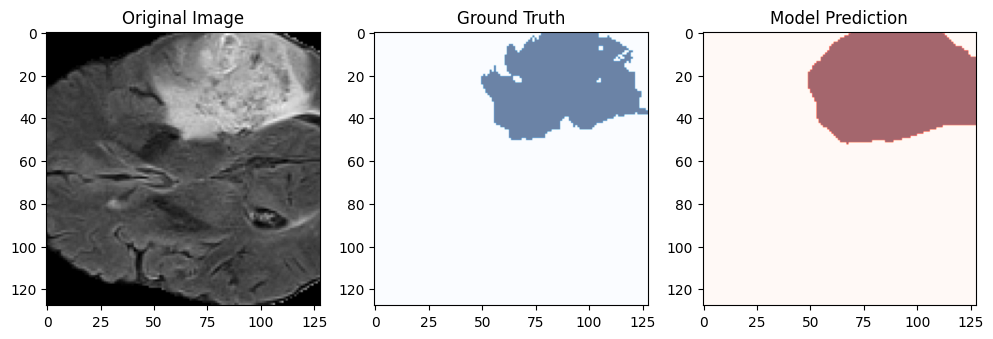

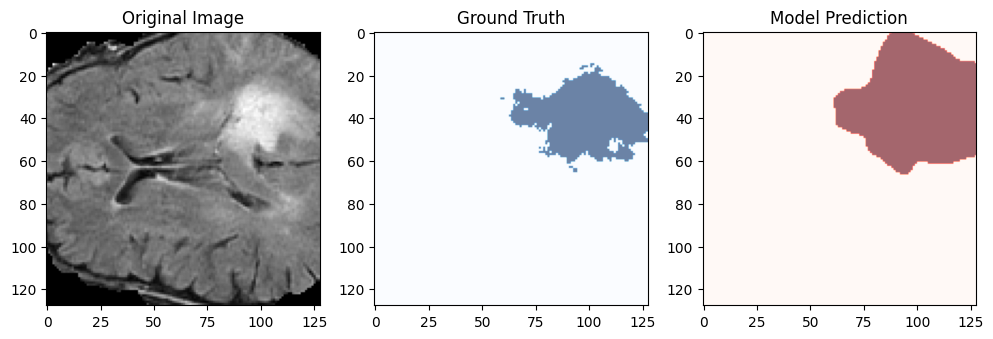

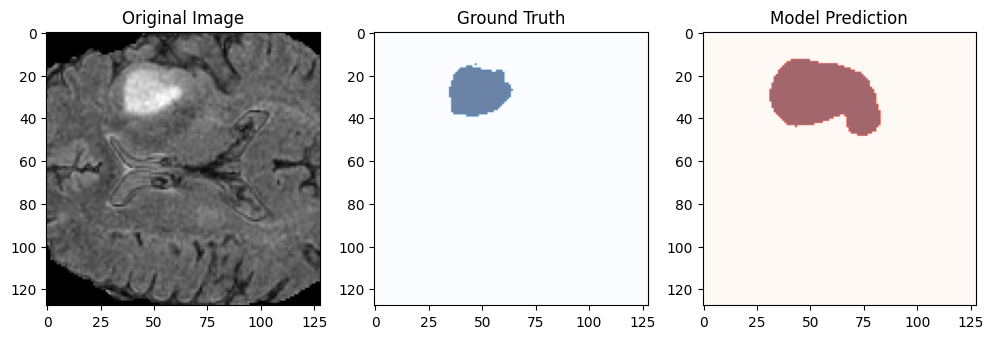

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt

num_samples = 3  # Number of images to visualize
sample_indices = random.sample(range(len(test_dataset)), num_samples)  # Random indices from test set

for i, idx in enumerate(sample_indices):
    sample = test_dataset[idx]
    image, label = sample["image"].to(device), sample["label"].to(device)

    # Ensure correct shape for model input
    image = image.unsqueeze(0)  # Add batch dimension

    # Get model prediction
    with torch.no_grad():
        output = model(image)

    # Convert tensors to numpy arrays
    output = post_pred(output).squeeze().cpu().numpy()   # Remove singleton dim
    label = post_label(label).squeeze().cpu().numpy()   # Remove singleton dim
    image = image.cpu().numpy().squeeze()

    # Select the middle slice along the depth axis
    middle_slice = image.shape[-1] // 2
    image_slice = image[..., middle_slice]  # Extract 2D slice
    label_slice = label[..., middle_slice]
    output_slice = output[..., middle_slice]

    # Ensure label and output slices are 2D
    label_slice = np.squeeze(label_slice)
    output_slice = np.squeeze(output_slice)

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].imshow(image_slice, cmap="gray")
    axs[0].set_title("Original Image")
    
    axs[1].imshow(label_slice, cmap="Blues", alpha=0.6)
    axs[1].set_title("Ground Truth")
    
    axs[2].imshow(output_slice, cmap="Reds", alpha=0.6)
    axs[2].set_title("Model Prediction")

    plt.show()


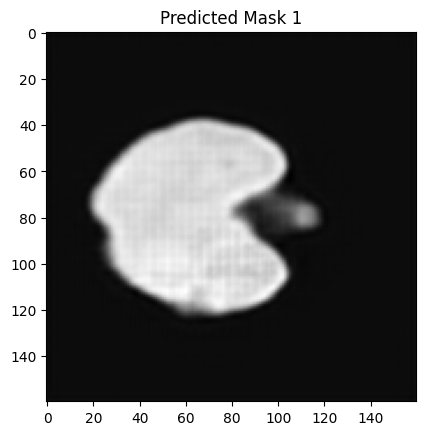

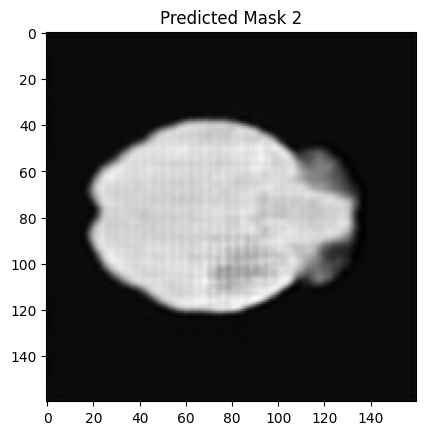

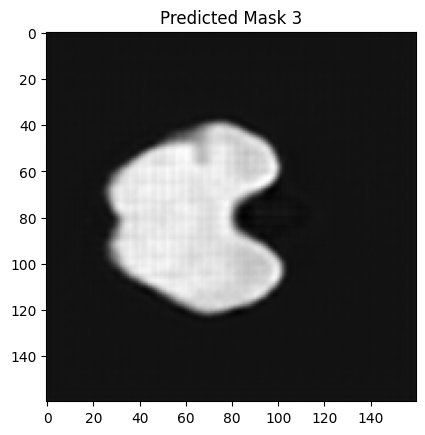

In [14]:
import torch
import matplotlib.pyplot as plt

model.eval()
val_outputs = []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch["image"].cuda()  # No labels
        outputs = model(inputs)
        val_outputs.append(outputs.cpu())

# Example: Plot a few predictions
for i in range(3):  # Show 3 random samples
    plt.imshow(val_outputs[i][0, 0, :, :, 50], cmap="gray")  # Show middle slice
    plt.title(f"Predicted Mask {i+1}")
    plt.show()


In [44]:
import os
import torch
from glob import glob
import numpy as np
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    ResizeWithPadOrCropd, ToTensord
)
from monai.data import Dataset, DataLoader
from monai.metrics import DiceMetric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score


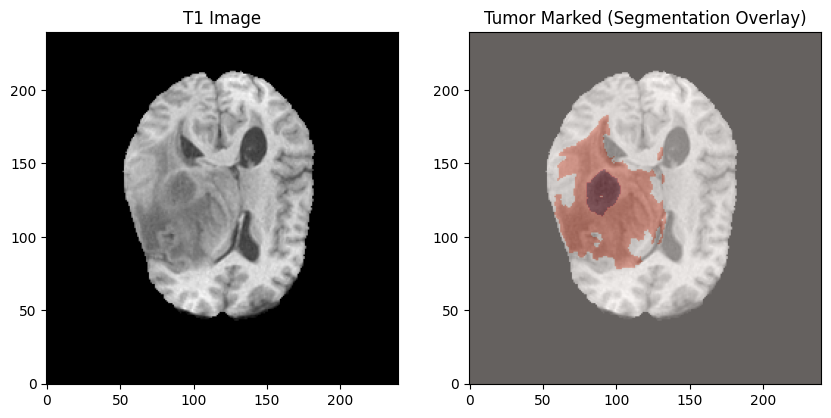

In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load image and segmentation
t1_path = 'D:\Major_Project_(CSE)\Brain_Tumor_Detection\dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii'
seg_path = "D:\Major_Project_(CSE)\Brain_Tumor_Detection\dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii"

t1_img = nib.load(t1_path).get_fdata()
seg_img = nib.load(seg_path).get_fdata()

# Pick a middle slice
slice_idx = t1_img.shape[2] // 2
t1_slice = t1_img[:, :, slice_idx]
seg_slice = seg_img[:, :, slice_idx]

# Plot with tumor overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(t1_slice.T, cmap='gray', origin='lower')
plt.title("T1 Image")

plt.subplot(1, 2, 2)
plt.imshow(t1_slice.T, cmap='gray', origin='lower')
plt.imshow(seg_slice.T, cmap='Reds', alpha=0.4, origin='lower')
plt.title("Tumor Marked (Segmentation Overlay)")

plt.show()


In [ ]:
pip install -U scikit-learn

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib

# Load metadata CSV (update the path if needed)
csv_path = r"D:\Major_Project_(CSE)\Brain_Tumor_Detection\survival_info.csv"
df = pd.read_csv(csv_path)

# Simulate tumor volume ‚Äî replace later with real extracted volume
np.random.seed(42)
df["tumor_volume"] = np.random.uniform(10000, 30000, size=len(df))

# Encode categorical field: Extent_of_Resection
le = LabelEncoder()
df["resection_encoded"] = le.fit_transform(df["Extent_of_Resection"])

# Feature matrix and target
X = df[["Age", "resection_encoded", "tumor_volume"]]
y = df["Survival_days"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("‚úÖ MAE:", mae)

# Save the model
output_path = r"D:\Major_Project_(CSE)\Brain_Tumor_Detection\rf_survival_model.pkl"
joblib.dump(model, output_path)
print("‚úÖ Model saved to:", output_path)


‚úÖ MAE: 307.0572916666667
‚úÖ Model saved to: D:\Major_Project_(CSE)\Brain_Tumor_Detection\rf_survival_model.pkl


In [24]:
import nibabel as nib
import numpy as np
import torch
import torch.nn.functional as F
from monai.networks.nets import UNet

# ==== Paths ====
MODEL_PATH = r"D:\Major_Project_(CSE)\Brain_Tumor_Detection\best_model.pth"
MRI_PATH = r"D:\Major_Project_(CSE)\Brain_Tumor_Detection\dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii" # Change to your test file

# ==== Load model ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ==== Load and preprocess MRI ====
img = nib.load(MRI_PATH)
volume = img.get_fdata()
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume) + 1e-8)

input_tensor = torch.tensor(volume, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)
input_tensor = F.interpolate(input_tensor, size=(128, 128, 128), mode='trilinear', align_corners=False).to(device)

# ==== Predict tumor mask ====
with torch.no_grad():
    output = model(input_tensor)
    output = torch.sigmoid(output)
    tumor_mask = (output > 0.5).float().cpu().numpy()[0, 0]

# ==== Compute tumor volume ====
voxel_volume_mm3 = np.prod(img.header.get_zooms())  # mm¬≥ per voxel
tumor_voxel_count = np.sum(tumor_mask)
tumor_volume_mm3 = tumor_voxel_count * voxel_volume_mm3
tumor_volume_cm3 = tumor_volume_mm3 / 1000  # convert to cm¬≥

print(f"üß™ Tumor volume: {tumor_volume_cm3:.2f} cm¬≥")


C:\Users\Kavya R\AppData\Local\Temp\ipykernel_9472\3562279380.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

üß™ Tumor volume: 283.75 cm¬≥


Found 12 healthy NIfTI files.


C:\Users\Kavya R\AppData\Local\Temp\ipykernel_3764\1907593913.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Original image shape: torch.Size([288, 288, 22])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[1] Tumor Voxels: 182068 ‚Üí Possible Tumor


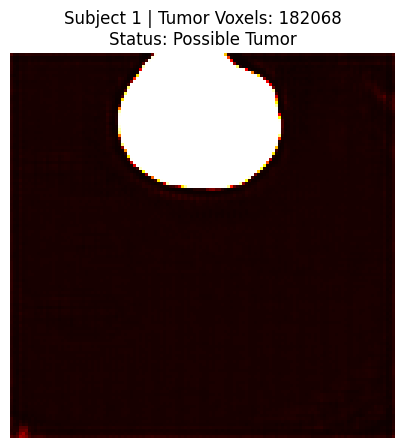

Original image shape: torch.Size([512, 512, 22])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[2] Tumor Voxels: 171427 ‚Üí Possible Tumor


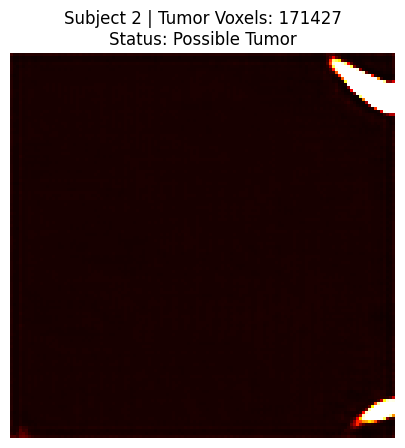

Original image shape: torch.Size([288, 288, 22])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[3] Tumor Voxels: 121226 ‚Üí Possible Tumor


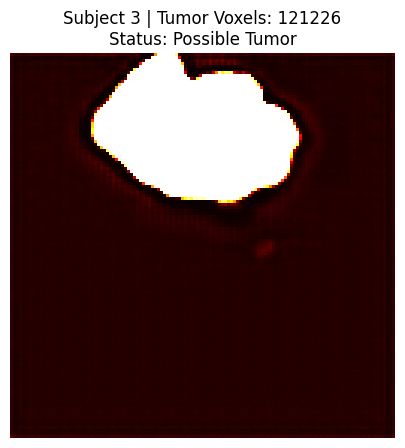

Original image shape: torch.Size([512, 512, 22])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[4] Tumor Voxels: 171540 ‚Üí Possible Tumor


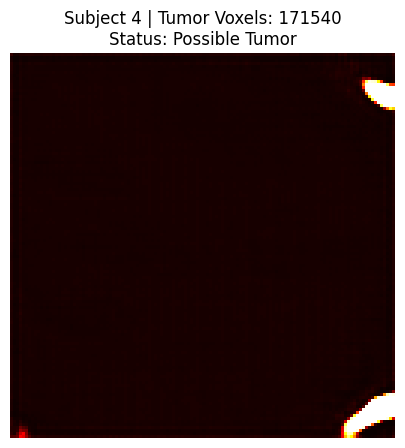

Original image shape: torch.Size([512, 512, 22])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[5] Tumor Voxels: 264367 ‚Üí Possible Tumor


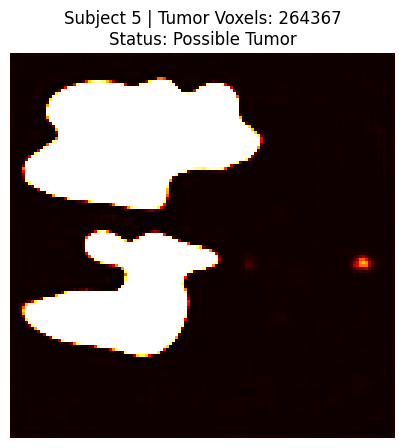

Original image shape: torch.Size([327, 576, 576])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[6] Tumor Voxels: 177818 ‚Üí Possible Tumor


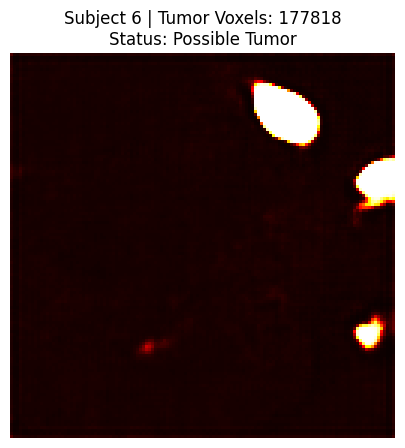

Original image shape: torch.Size([170, 256, 256])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[7] Tumor Voxels: 205311 ‚Üí Possible Tumor


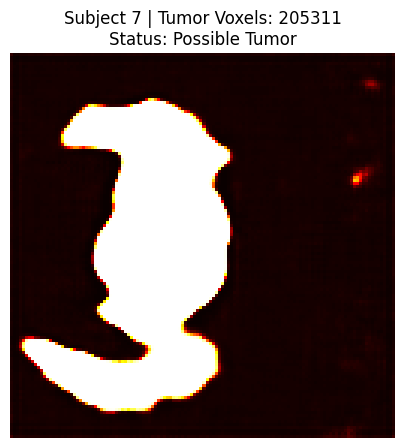

Original image shape: torch.Size([180, 256, 256])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[8] Tumor Voxels: 201884 ‚Üí Possible Tumor


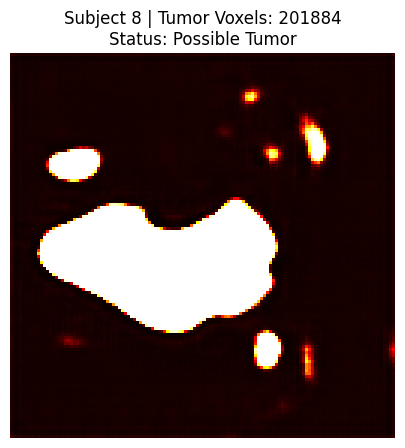

Original image shape: torch.Size([327, 576, 576])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[9] Tumor Voxels: 137286 ‚Üí Possible Tumor


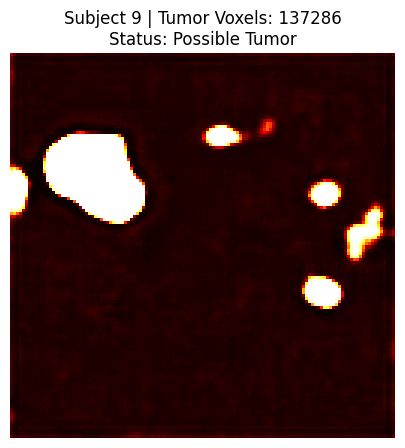

Original image shape: torch.Size([170, 256, 256])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[10] Tumor Voxels: 166334 ‚Üí Possible Tumor


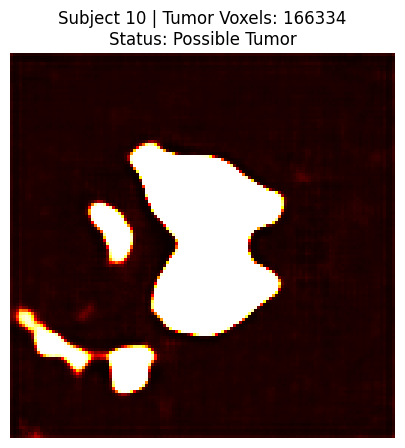

Original image shape: torch.Size([180, 256, 256])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[11] Tumor Voxels: 178891 ‚Üí Possible Tumor


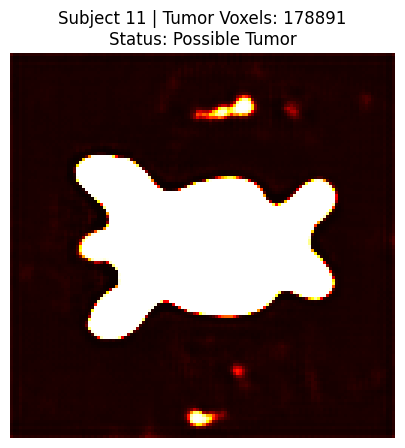

Original image shape: torch.Size([182, 218, 182])
Processed image shape: torch.Size([1, 1, 128, 128, 128])
[12] Tumor Voxels: 223624 ‚Üí Possible Tumor


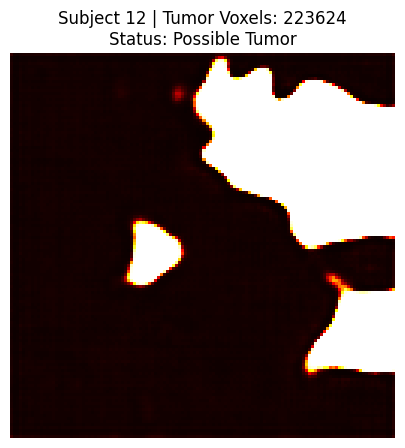

In [15]:
# ====== COLLECT NIFTI FILES ======
healthy_files = []
for root, dirs, files in os.walk(HEALTHY_DIR):
    for f in files:
        if f.endswith(".nii") or f.endswith(".nii.gz"):
            healthy_files.append(os.path.join(root, f))

print(f"Found {len(healthy_files)} healthy NIfTI files.")

# ====== DEFINE MONAI TRANSFORMS ======

# Custom function to add channel dimension
def add_channel(data):
    image = data["image"]  # Assuming your data dictionary has an "image" key
    print(f"Original image shape: {image.shape}")
    data["image"] = image.unsqueeze(0)  # Add channel dimension and keep in dictionary format
    return data


transforms = Compose([
    LoadImaged(keys=["image"]),  # Loads NIfTI file into a dictionary with "image" key
    Lambda(func=add_channel),  # Manually add channel without the 'keys' argument
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    Orientationd(keys=["image"], axcodes="RAS"),
    ScaleIntensityd(keys=["image"]),
    ResizeWithPadOrCropd(keys=["image"], spatial_size=(128, 128, 128)),
    ToTensord(keys=["image"]),
])

# ====== CREATE DATASET & LOADER ======
# Loading NIfTI files into a dictionary format with the key "image"
data_dicts = [{"image": file} for file in healthy_files]  # file is the path to the NIfTI image
dataset = Dataset(data=data_dicts, transform=transforms)
loader = DataLoader(dataset, batch_size=1)

# ====== LOAD MODEL ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ====== PREDICT & VISUALIZE ======
with torch.no_grad():
    for i, batch in enumerate(loader):
        image = batch["image"].to(device)
        print(f"Processed image shape: {image.shape}")
        output = model(image)
        prediction = torch.sigmoid(output).cpu().numpy()[0, 0]

        tumor_voxels = np.sum(prediction > 0.5)
        status = "Possible Tumor" if tumor_voxels > 500 else "Likely Healthy"

        print(f"[{i+1}] Tumor Voxels: {tumor_voxels} ‚Üí {status}")

        # Show middle slice
        mid_slice = prediction.shape[2] // 2
        plt.figure(figsize=(6, 5))
        plt.imshow(prediction[:, :, mid_slice], cmap="hot")
        plt.title(f"Subject {i+1} | Tumor Voxels: {tumor_voxels}\nStatus: {status}")
        plt.axis("off")
        plt.show()
